# TP  Evolution de la population des communes françaises 

Cody ADAM

Février 2023 

Objectifs du TP 
----------------

+ Utiliser le module pandas et les structures de données qu'il introduit (au dessus de numpy)
    + Séries 
    + DataFrame 
+ Pratiquer pandas sur un cas concret (études des communes françaises)
    + Lecture 
    + Mise en forme, gestion des données invalides
    + Association entre différentes sources de données (merge) 
    + Visualisation (scatter plot)
+ Ajouter d'autres visualisations

#  Etude des Communes Françaises

In [29]:
from IPython.display import Image
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


Vous disposez sur moodle d'une archive contenant différents fichiers sélectionnés pour les besoins du TP. 
En particulier: 

+  `commune1.csv` est un fichier qui contient l'évolution démographique de toutes les communes française depuis 1975 ainsi que les coordonnées géographiques (longitude,latitude) de la commune. Ce fichier est volumineux et découpés en 2 archives zip.
+ `commune2.csv`est un fichier d'une autre source qui contient entre autres les codes postaux des communes 
+ `maires-25-04-2014.xslx` contient la liste des maires de France. 
+ `insee.csv` 


Sur la figure ci-dessous chaque point correspond à une commune. 

## Lecture de fichiers

In [30]:
commune = pd.read_csv("commune1.csv", sep=",", encoding="utf-8")
insee = pd.read_csv("Insee.csv", sep=";", encoding="utf-8")
maires = pd.read_excel("maires.xlsx", skiprows=3)

In [31]:
commune.head()

reg  dep  com article                     com_nom      long        lat  \
0   11   75   56     NaN                       PARIS  2.352222  48.856614   
1   11   77    1     NaN            ACHERES-LA-FORET  2.570289  48.354976   
2   11   77   10     NaN  AUBEPIERRE-OZOUER-LE-REPOS  2.890552  48.632323   
3   11   77  100      LE            CHATELET-EN-BRIE  2.792095  48.504945   
4   11   77  101     NaN          CHATENAY-SUR-SEINE  3.096229  48.418774   

       pop_1975      pop_1976      pop_1977  ...      pop_2001      pop_2002  \
0  2.294116e+06  2.277408e+06  2.261510e+06  ...  2.142425e+06  2.149205e+06   
1  6.482592e+02  6.620875e+02  6.763429e+02  ...  1.106389e+03  1.126294e+03   
2  5.874394e+02  5.995405e+02  6.118238e+02  ...  8.738642e+02  8.797754e+02   
3  2.251402e+03  2.481846e+03  2.695300e+03  ...  4.408286e+03  4.407891e+03   
4  5.071603e+02  5.391894e+02  5.699313e+02  ...  9.284420e+02  9.278621e+02   

       pop_2003      pop_2004      pop_2005      pop_2006      pop_2007  \
0  2.156989e+06  2.165785e+06  2.175600e+06  2.186440e+06  2.198315e+06   
1  1.146224e+03  1.166163e+03  1.186095e+03  1.206006e+03  1.225880e+03   
2  8.849946e+02  8.894883e+02  8.932229e+02  8.961646e+02  8.982798e+02   
3  4.407379e+03  4.407398e+03  4.408599e+03  4.411630e+03  4.417140e+03   
4  9.260636e+02  9.230492e+02  9.188215e+02  9.133832e+02  9.067369e+02   

       pop_2008      pop_2009      pop_2010  
0  2.211230e+06  2.225194e+06  2.240213e+06  
1  1.245702e+03  1.265455e+03  1.285127e+03  
2  8.995351e+02  8.998966e+02  8.993365e+02  
3  4.425779e+03  4.438194e+03  4.454928e+03  
4  8.988853e+02  8.898310e+02  8.795762e+02  

[5 rows x 43 columns]

In [32]:
insee.head()

Commune Codepos Departement  INSEE
0  ABERGEMENT CLEMENCIAT   01400         AIN   1001
1    ABERGEMENT DE VAREY   01640         AIN   1002
2               AMAREINS   01090         AIN   1003
3      AMBERIEU EN BUGEY   01500         AIN   1004
4    AMBERIEUX EN DOMBES   01330         AIN   1005

In [33]:

maires.head()

Code du département (Maire) Libellé de département (Maires)  \
0                           1                             AIN   
1                           1                             AIN   
2                           1                             AIN   
3                           1                             AIN   
4                           1                             AIN   

  Code Insee de la commune    Libellé de la commune  Population de la commune  \
0                        1  L'Abergement-Clémenciat                     780.0   
1                        2    L'Abergement-de-Varey                     234.0   
2                        4        Ambérieu-en-Bugey                   13839.0   
3                        5      Ambérieux-en-Dombes                    1600.0   
4                        6                  Ambléon                     112.0   

  Nom de l'élu Prénom de l'élu Civilité Date de naissance  Code profession  \
0       BOULON          Daniel        M        1951-03-04             61.0   
1        ORSET             Max        M        1947-11-02             65.0   
2        FABRE          Daniel        M        1961-09-07             51.0   
3       PERNET          Pierre        M        1961-07-29             42.0   
4       BIONDA           Annie      Mme        1951-11-28             63.0   

                Libellé de la profession  
0              Retraités salariés privés  
1                       Autres retraités  
2         Cadres (entreprises publiques)  
3    Professeurs du secondaire et techn.  
4  Retraités fonct.publique (sf enseig.)

## Nettoyage et fusion (Merge) de tous les `DataFrame`

On ajoute le code INSEE à toutes les tables s'il n'est pas déjà présent. Cette colonne sera notre pivot pour les jointures.

Le code INSEE est composé de 5 chiffres.

`<Code INSEE> = <Code département> * 1000 + <Code commune>`

In [34]:
commune["INSEE"] = commune.apply(lambda x: int(x["dep"]) * 1000 + int(x["com"]), axis=1)

# remove any non numeric department code
maires = maires[maires["Code du département (Maire)"].apply(lambda x: str(x).isnumeric())]
maires["INSEE"] = maires.apply(lambda x: int(x["Code du département (Maire)"]) * 1000 + int(x["Code Insee de la commune"]), axis=1)


In [35]:
com = commune.merge(insee, on="INSEE", how="inner")
com = com.merge(maires, on="INSEE", how="inner")

com.head()

reg  dep  com article                     com_nom      long        lat  \
0   11   77    1     NaN            ACHERES-LA-FORET  2.570289  48.354976   
1   11   77   10     NaN  AUBEPIERRE-OZOUER-LE-REPOS  2.890552  48.632323   
2   11   77  100      LE            CHATELET-EN-BRIE  2.792095  48.504945   
3   11   77  101     NaN          CHATENAY-SUR-SEINE  3.096229  48.418774   
4   11   77  102     NaN                    CHATENOY  2.625239  48.233563   

      pop_1975     pop_1976     pop_1977  ...  \
0   648.259242   662.087472   676.342899  ...   
1   587.439368   599.540499   611.823807  ...   
2  2251.401706  2481.846183  2695.299617  ...   
3   507.160272   539.189398   569.931319  ...   
4   131.539347   127.684799   124.269462  ...   

   Libellé de département (Maires)  Code Insee de la commune  \
0                  SEINE ET MARNE                          1   
1                  SEINE ET MARNE                         10   
2                  SEINE ET MARNE                        100   
3                  SEINE ET MARNE                        101   
4                  SEINE ET MARNE                        102   

        Libellé de la commune  Population de la commune  Nom de l'élu  \
0            Achères-la-Forêt                    1232.0      MALCHERE   
1  Aubepierre-Ozouer-le-Repos                     895.0       CUYPERS   
2         Le Châtelet-en-Brie                    4413.0        MAZARD   
3          Châtenay-sur-Seine                     955.0         BIGOT   
4                    Châtenoy                     155.0       CELADON   

   Prénom de l'élu  Civilité  Date de naissance  Code profession  \
0          Patrice         M         1953-07-03              1.0   
1           Pierre         M         1944-03-23              1.0   
2            Alain         M         1943-11-01             61.0   
3        Jean Yves         M         1947-08-12             65.0   
4            Denis         M         1962-04-23             51.0   

              Libellé de la profession  
0  Agriculteurs propriétaires exploit.  
1  Agriculteurs propriétaires exploit.  
2            Retraités salariés privés  
3                     Autres retraités  
4       Cadres (entreprises publiques)  

[5 rows x 58 columns]

## Affichage de la densité de population en France en 1975

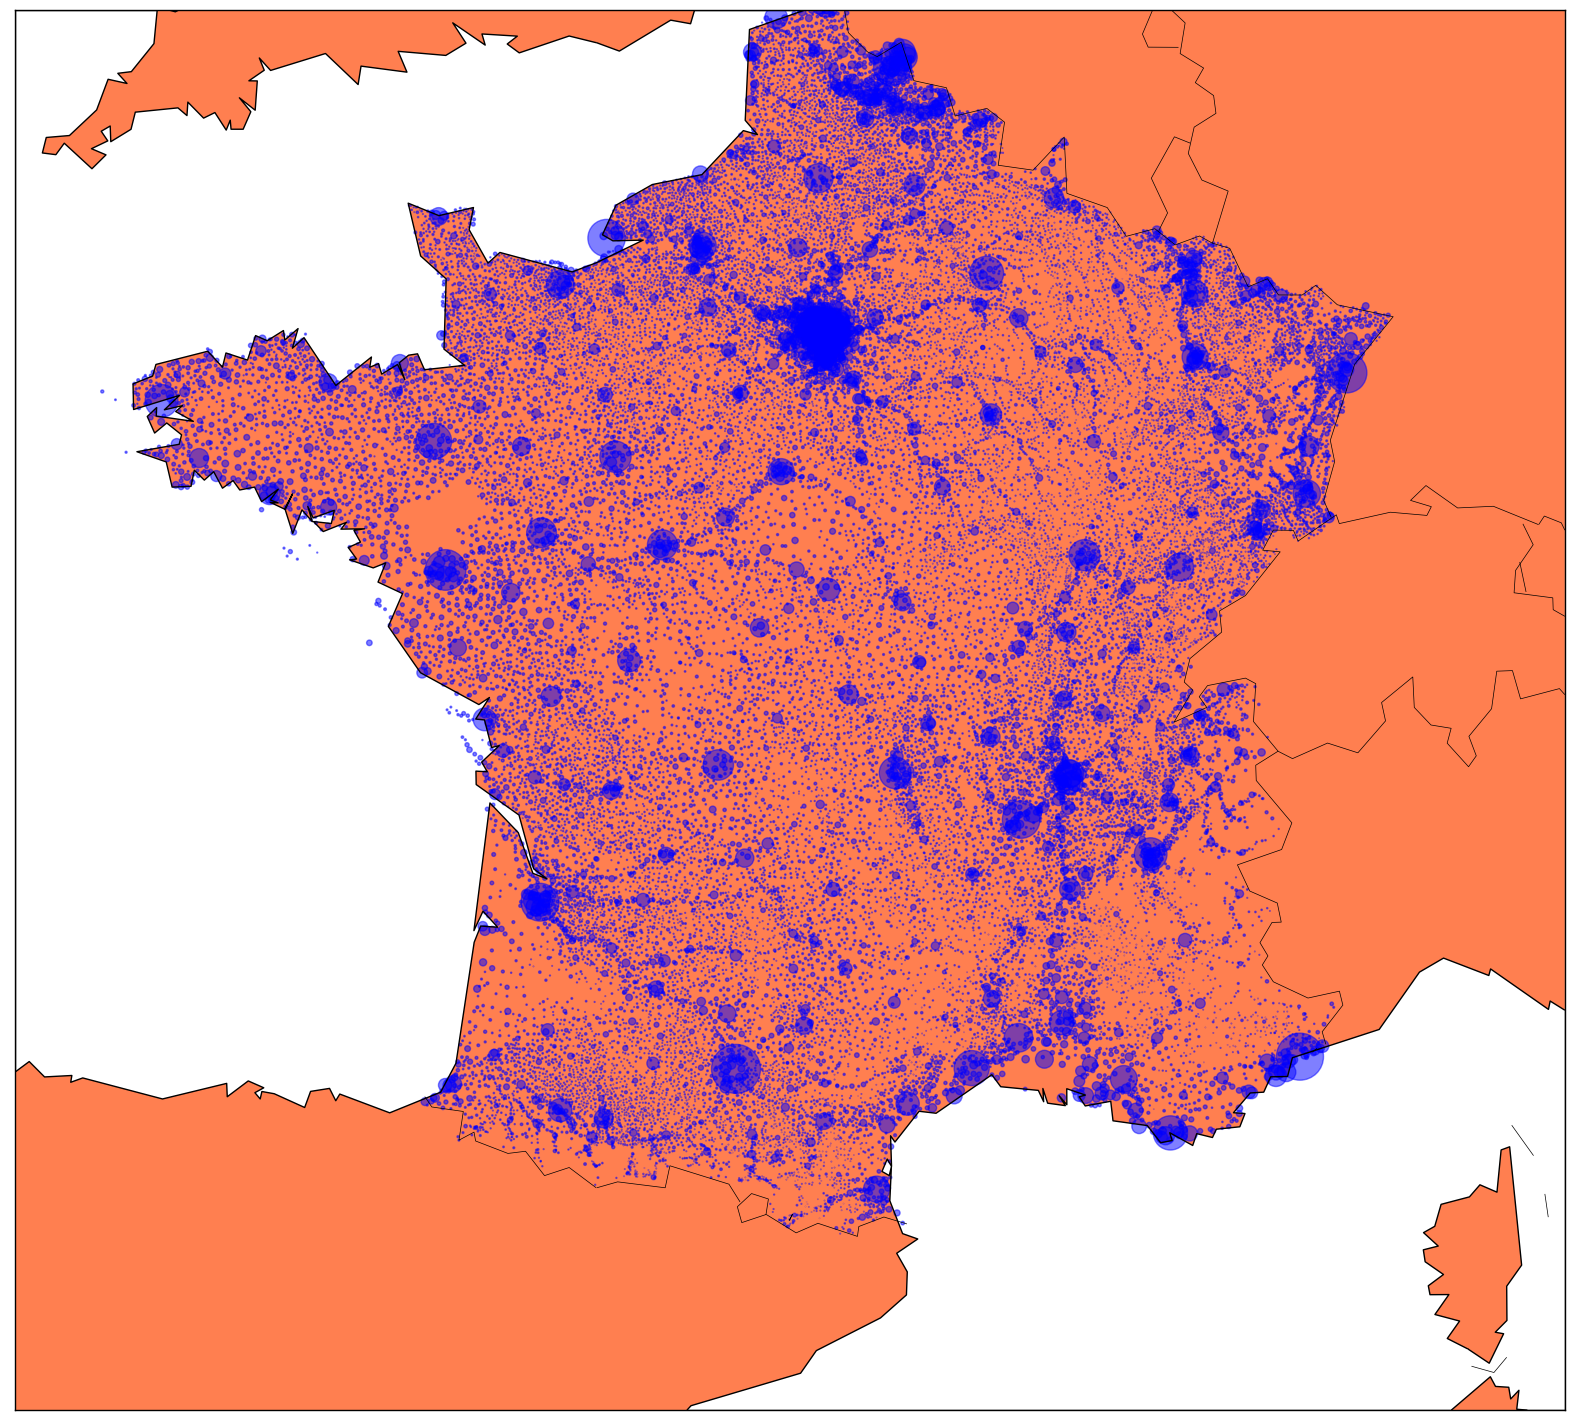

In [36]:

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=41, urcrnrlat=51, llcrnrlon=-6, urcrnrlon=10, lat_ts=20, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.fillcontinents(color='coral',lake_color='aqua')

x, y = m(com["long"].values, com["lat"].values)
pop = com["pop_1975"].values
size = pop/300
plt.scatter(x, y, s=size, c="blue", alpha=0.5)




Sur la visualisation ci-dessous, chaque point correspond à une commune. La taille du point est proportionnelle à la densité de population de la commune.
On peut bien voir resortir les grandes villes telles que Paris, Lyon, Marseille, Lille, Toulouse, Bordeaux, Nice, Nantes, etc...

## Affichage des communes selon l'âge de leur maire

min age:  29
max age:  101


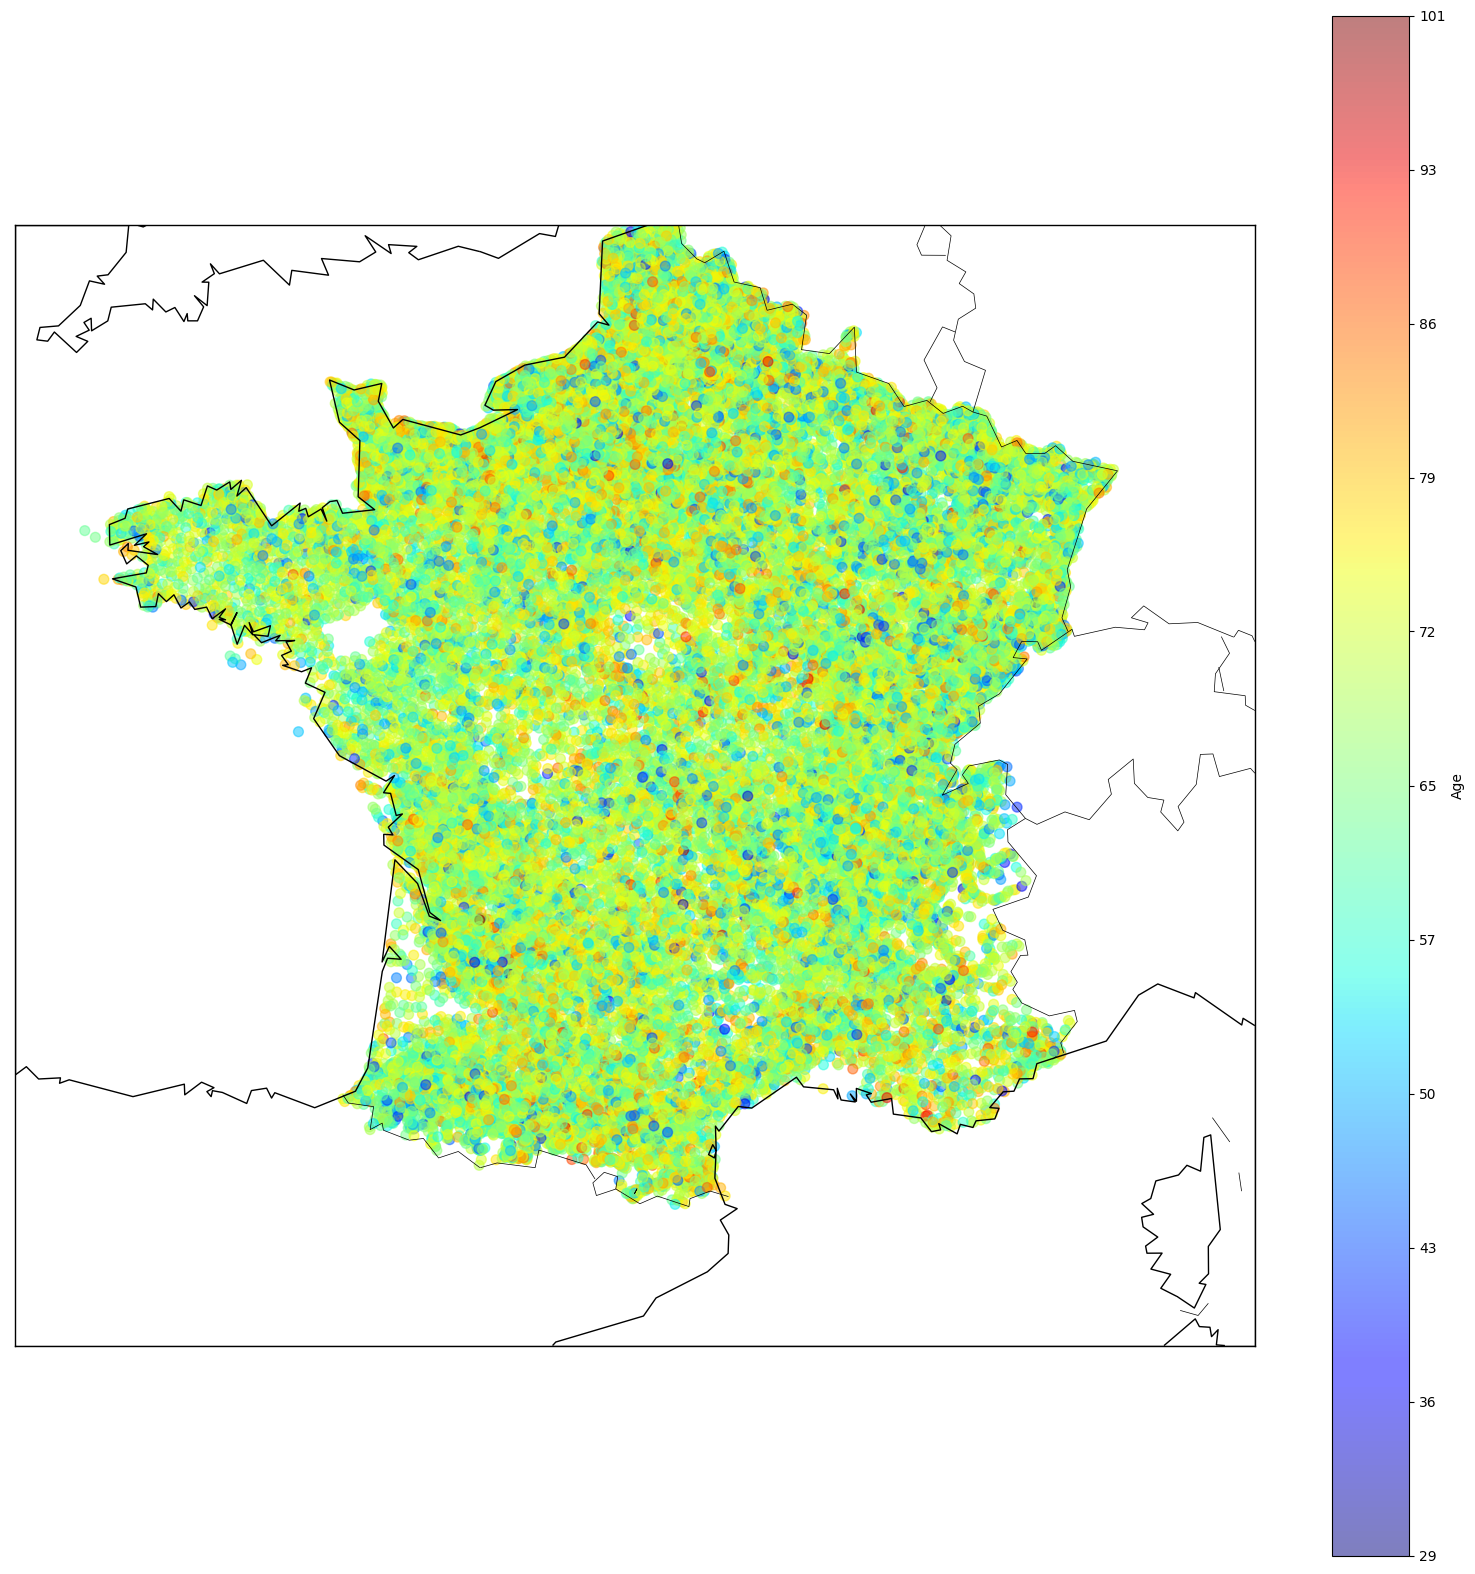

In [37]:

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=41, urcrnrlat=51, llcrnrlon=-6, urcrnrlon=10, lat_ts=20, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.fillcontinents(color='white',lake_color='blue')

x, y = m(com["long"].values, com["lat"].values)
birthDate = com["Date de naissance"].values
now = pd.to_datetime("now", utc=True)
age = now.year - pd.to_datetime(birthDate).year

minAge = age.min()
maxAge = age.max()
print("min age: ", minAge)
print("max age: ", maxAge)

# t from age (min-max) -> (0.0-1.0)
t = (age - minAge) / (maxAge - minAge)

# Create a heatmap of the age of the mayors
plt.scatter(x, y, s=50, c=t, alpha=0.5, cmap="jet")
# Add a colorbar with the age scale
bar = plt.colorbar()
bar.set_label("Age")
bar.set_ticks(np.linspace(0, 1, 11))
bar.set_ticklabels(np.linspace(minAge, maxAge, 11).astype(int))


Graphiquement nous ne pouvons pas en tirer grand chose. Essayons de faire un histogramme.

Text(0, 0.5, 'Number of mayors')

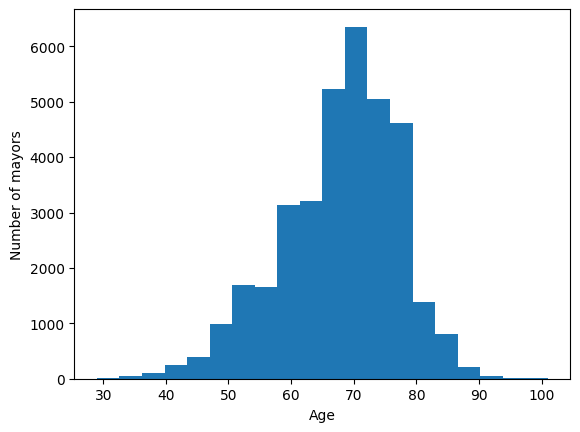

In [38]:
# Histogram of the age of the mayors
plt.hist(age, bins=20)
plt.xlabel("Age")
plt.ylabel("Number of mayors")


Cette fois ci nous pouvons voir que la majorité des maires ont entre 60 et 80 ans.
Intéressons nous maintenant à la densité de population des communes et la relation avec l'âge des maires.

Text(0, 0.5, 'Population')

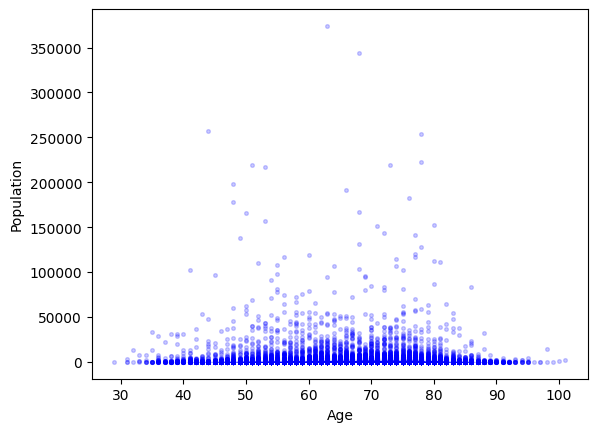

In [39]:
# 2d plot of age of mayors related to population
plt.scatter(age, com["pop_1975"], s=7, c="blue", alpha=0.2)
plt.xlabel("Age")
plt.ylabel("Population")


À partir du précédent graphique, on peut voir deux pics :

![conclusion](img/ageanalysis.png)

(les outliers en jaune)

On peut voir que il y a deux pics, un à 55 ans et un autre à 75 ans. Cela signifie qu'il y a une tendance avec les communes de beaucoup d'habitants. Elles ont des maires soit de la génération des 55 ans, soit de la génération des 75 ans (environs).

## Analyse demandées

+ Construire une fonction qui évalue le taux de croissance de la population entre deux années consécutives. 

+ Visualiser avec la fonction `plt.scatter` la croissance ou la décroissance de la population
+ Proposer des visualisations de la répartition des communes en fonction de différents critères (superficie, prénom du maire, ...)

## Analyse de la croissance de la population

In [40]:
def rateOfGrowht(year1, year2, pop1, pop2):
    return (pop2 - pop1) / (year2 - year1)

Text(0.5, 1.0, 'Rate of growth of the population between 1975 and 2010')

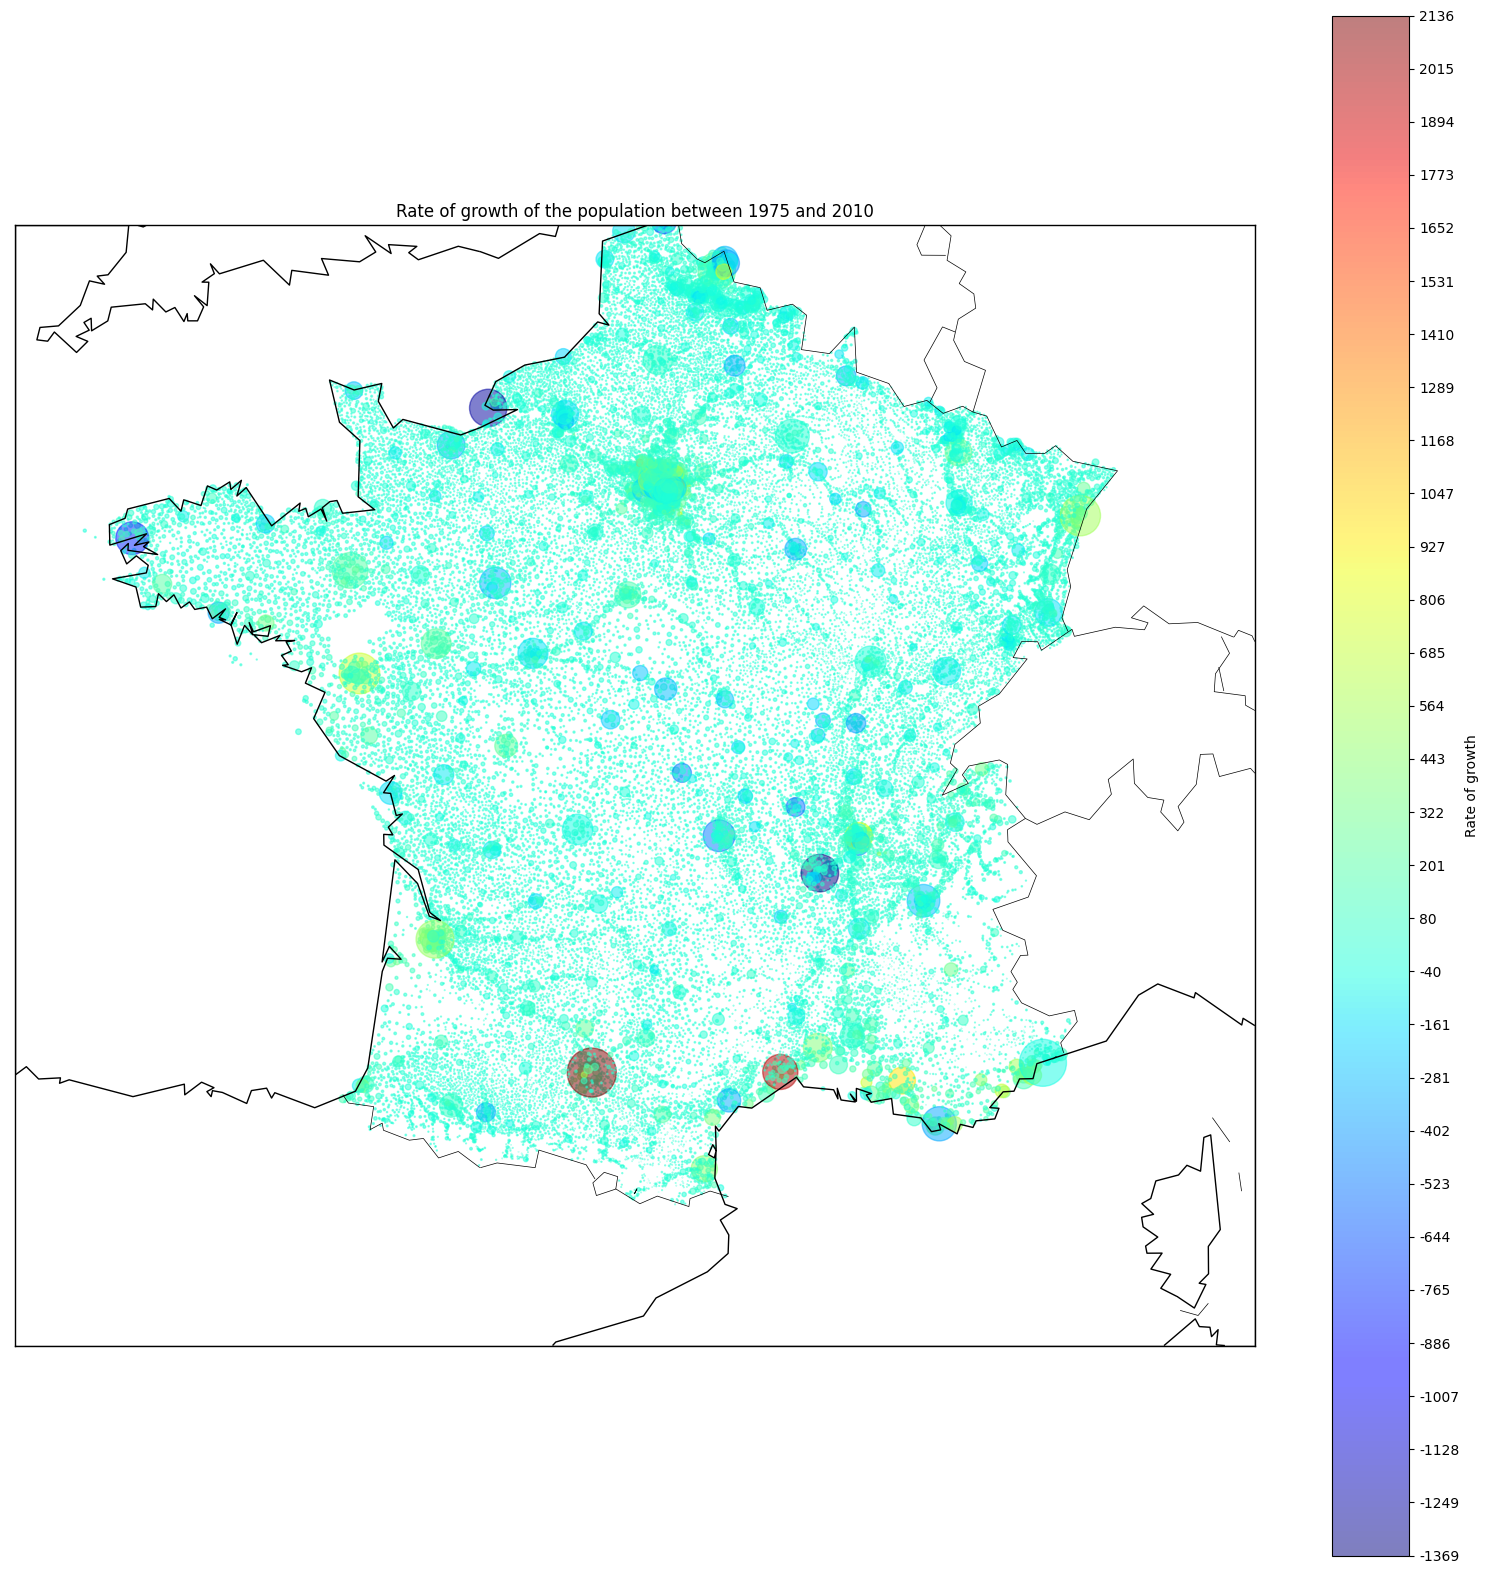

In [41]:
# plot the map of the rate of growth of the population (big cities have a higher rate of growth)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=41, urcrnrlat=51, llcrnrlon=-6, urcrnrlon=10, lat_ts=20, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.fillcontinents(color='white',lake_color='blue')

x, y = m(com["long"].values, com["lat"].values)
pop1975 = com["pop_1975"].values
pop2010 = com["pop_2010"].values
rate = rateOfGrowht(1975, 2010, pop1975, pop2010)
size = pop1975/300
plt.scatter(x, y, s=size, c=rate, alpha=0.5, cmap="jet")
bar = plt.colorbar()
bar.set_label("Rate of growth")
bar.set_ticks(np.linspace(rate.min(), rate.max(), 30))
bar.set_ticklabels(np.linspace(rate.min(), rate.max(), 30).astype(int))
plt.title("Rate of growth of the population between 1975 and 2010")


Plus le cercle est grand, plus la population a évolué (en 1975).
La couleur du cercle indique l'évolution de la population. Le rouge signifie que la population a augmenté, le bleu signifie que la population a diminué.


La majorité des communes ont une population qui sont stable ou qui augmente légèrement. Cela est causé par la présence de villes qui ont une population qui évolue fortement. 

Essayons de supprimer les villes qui ont une population qui évolue fortement (**supprimer les outliers**) pour mieux voir la répartition des communes.



Text(0.5, 1.0, 'Rate of growth of the population (without outliers)')

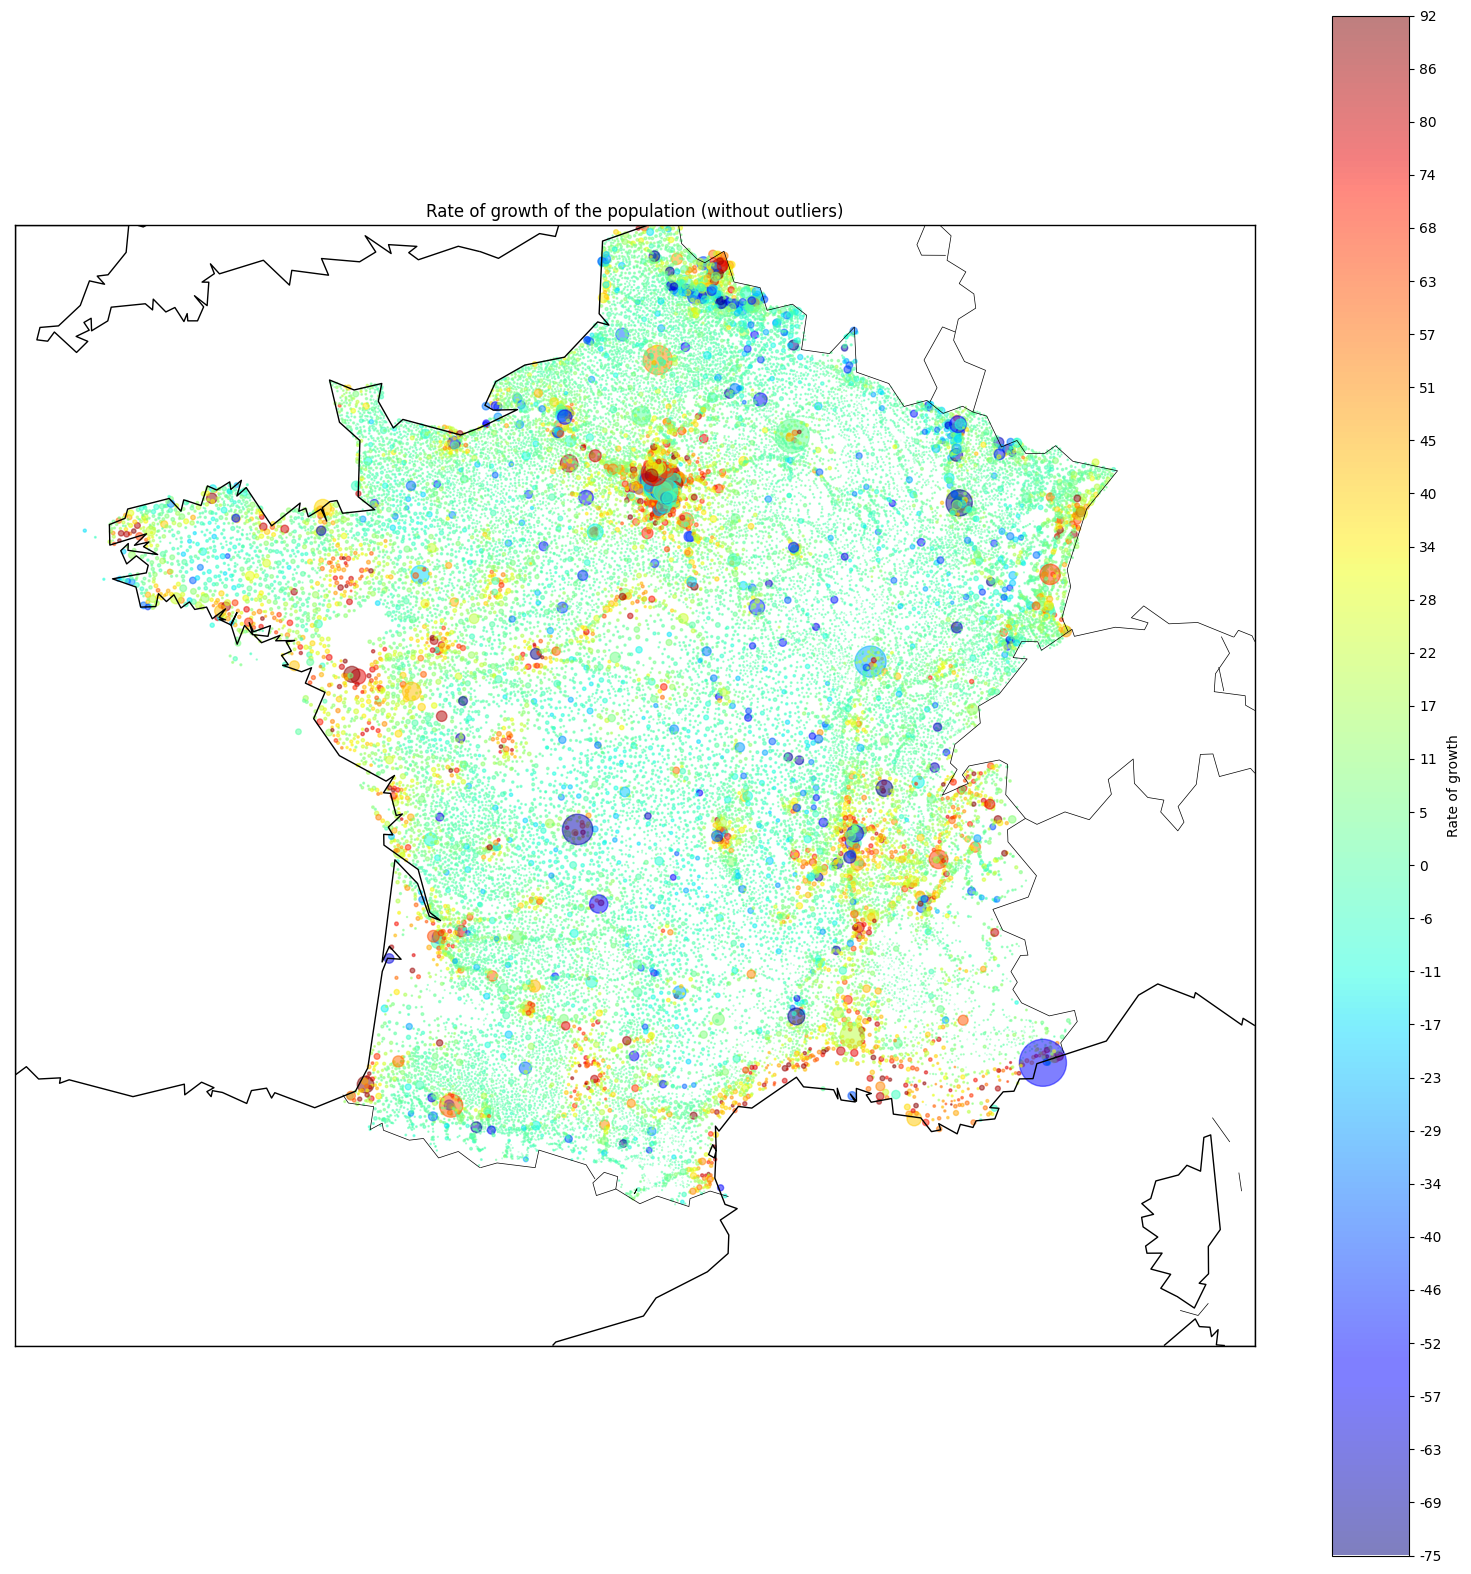

In [42]:
# same but without the outliers
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=41, urcrnrlat=51, llcrnrlon=-6, urcrnrlon=10, lat_ts=20, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.fillcontinents(color='white',lake_color='blue')

x, y = m(com["long"].values, com["lat"].values)
pop1975 = com["pop_1975"].values
pop2010 = com["pop_2010"].values
rate = rateOfGrowht(1975, 2010, pop1975, pop2010)
min_rate = rate.min()
max_rate = rate.max()
mean_rate = rate.mean()
std_rate = rate.std()
min_treshold = mean_rate - 2 * std_rate
max_treshold = mean_rate + 2 * std_rate

# remove outliers
for i in range(len(rate)):
    if rate[i] < min_treshold or rate[i] > max_treshold:
        rate[i] = np.nan
        
size = pop1975/300
plt.scatter(x, y, s=size, c=rate, alpha=0.5, cmap="jet")
bar = plt.colorbar()
bar.set_label("Rate of growth")
bar.set_ticks(np.linspace(min_treshold, max_treshold, 30))
bar.set_ticklabels(np.linspace(min_treshold, max_treshold, 30).astype(int))
plt.title("Rate of growth of the population (without outliers)")


Il est maintenant plus facile de voir l'évolution de la population des communes selon leur zone géographique. 

On peut voir que la majorité des communes en bord de mer ont une population qui augmente (en rouge).

Mais il y a également des communes qui ont une population qui diminue (en blue).


![growth](img/growth.png)

Text(0, 0.5, 'Gain en population')

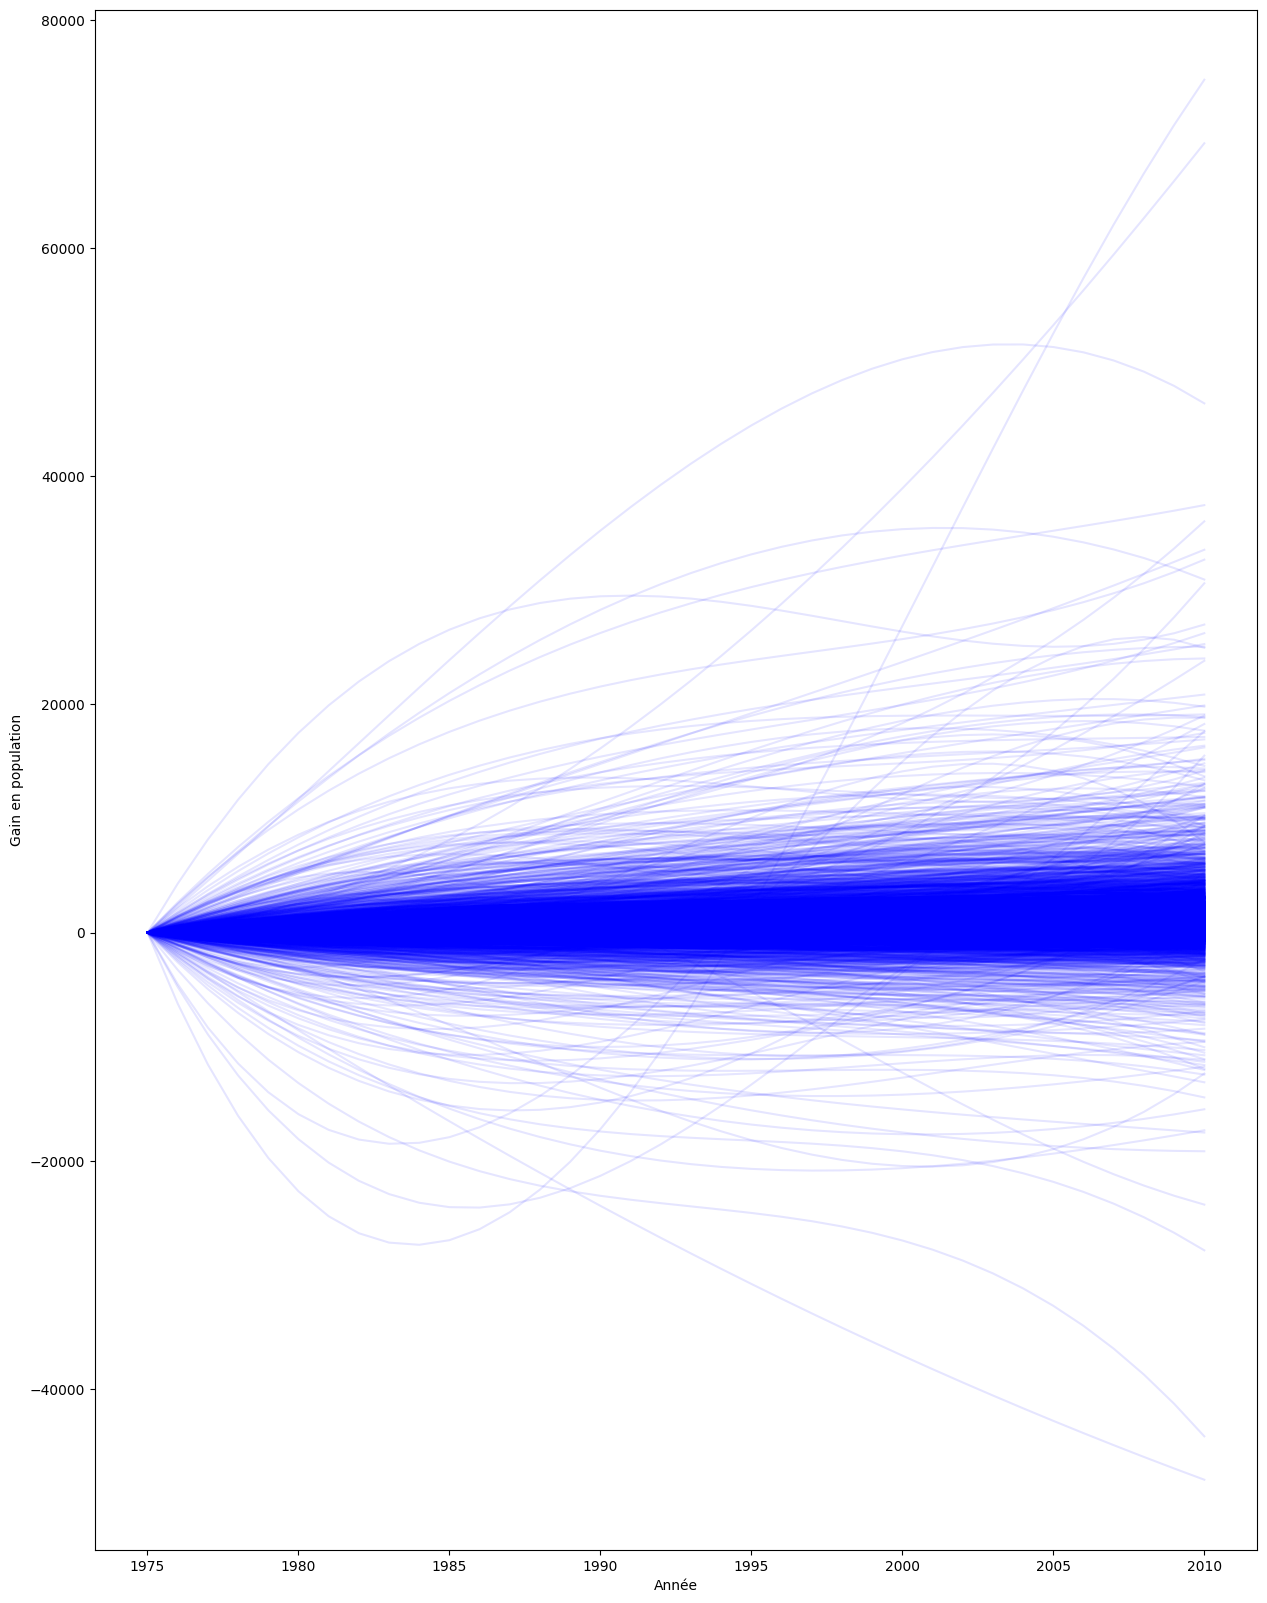

In [43]:
# plot the population of all the cities in 1975 up to 2010 on the same graph

from collections import defaultdict


pops = defaultdict(list)
for c in com.to_dict("records"):
    offset = c["pop_1975"]
    for year in range(1975, 2011):
        pops[c["com_nom"]].append(c["pop_" + str(year)] - offset)

fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(111)
for name, pop in pops.items():
    if len(pop) != 36:
        continue
    X = range(1975, 2011)
    plt.plot(X, pop, label=name, alpha=0.1, c="blue")
plt.xlabel("Année")
plt.ylabel("Gain en population")



Sur ce graphique, nous pouvons voir que la population de la tendance générale est stable. 

Cependant, nous pouvons voir qu'il y a quelques cas où la population augmente fortement ou bien fait des variations importantes. Par exemple, la ville de Toulouse a une croissance démographique très élevée à partir de 1985.